# CNN

In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# 이미지 크기가 제각각이라 맞춤
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames=os.listdir("CNN_dataset/sleep_wake")
categories=[]  # sleep : 1, wake : 0 => y 데이터 추가
for fn in filenames: 
    ct=fn.split(".")[0]
    if ct=='sleep':
        categories.append(1)
    else:
        categories.append(0)

In [4]:
len(categories)

2400

In [5]:
df=pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})
df

,filename,category
0,sleep.0.jpg,1
1,sleep.1.jpg,1
2,sleep.10.jpg,1
3,sleep.100.jpg,1
4,sleep.1000.jpg,1
...,...,...
2395,wake.995.jpg,0
2396,wake.996.jpg,0
2397,wake.997.jpg,0
2398,wake.998.jpg,0


In [6]:
sample=random.choice(filenames)  # 사진 샘플 하나 뽑기

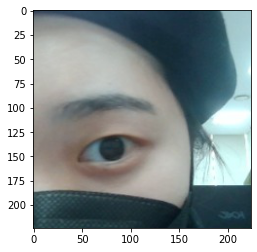

In [7]:
img=load_img("CNN_dataset/sleep_wake/"+sample) # 이미지 로드
plt.imshow(img)

In [8]:
model = Sequential()

In [9]:
# Conv2D : 1D(1차원, 길게~), 2D(2차원, 사각영역), 3D(영상)
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [11]:
earlystop = EarlyStopping(patience=10) # 10번이상 모델이 개선되지 않으면 멈춤

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)  # learning_rate의 하한값

In [13]:
callbacks = [earlystop, learning_rate_reduction]

In [14]:
df["category"] = df["category"].replace({1: 'sleep', 0: 'wake'})

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

In [16]:
total_train = train_df.shape[0]  # train_df : 증식시켜야 할 데이터 
total_validate = validate_df.shape[0]
batch_size=15

In [17]:
# 이미지 증식
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [18]:
# flow_from_dataframe
# train_df : 증식시켜야 할 데이터가 데이터프레임이므로
train_generator=train_datagen.flow_from_dataframe(
    train_df,
    "CNN_dataset/sleep_wake/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1920 validated image filenames belonging to 2 classes.


In [19]:
# validation 데이터는 증식하면 안됨
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "CNN_dataset/sleep_wake/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 480 validated image filenames belonging to 2 classes.


In [20]:
epochs=20

In [21]:
batch_size=15

In [23]:
history=model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

In [50]:
model.save("./cnn_model.h5")

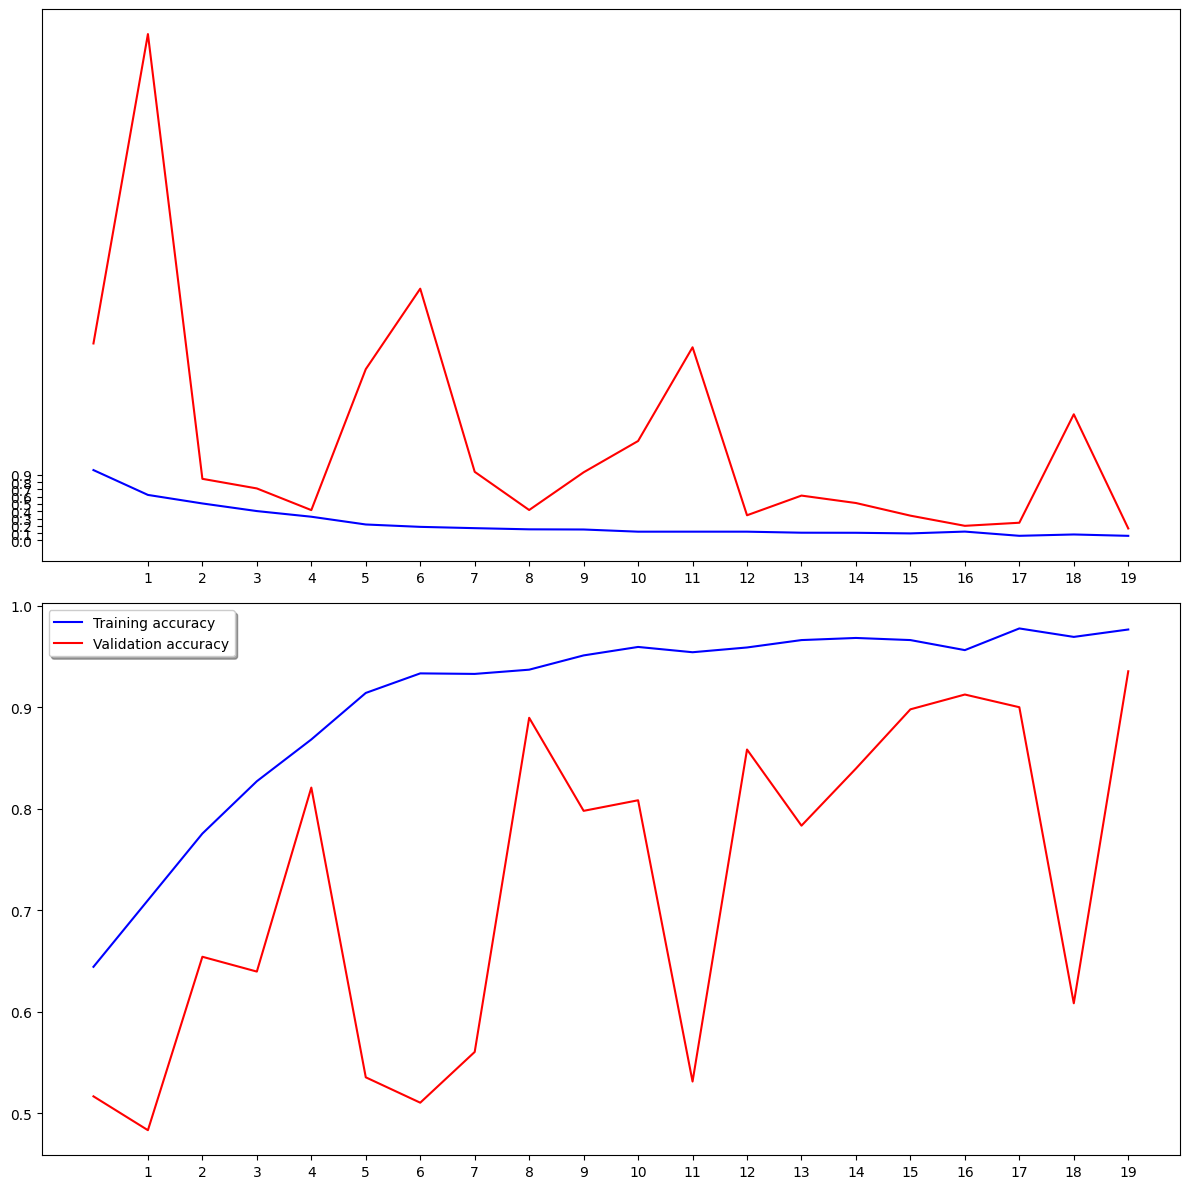

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [75]:
#test
test_filenames = os.listdir("CNN_dataset/cnn_test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [76]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "CNN_dataset/cnn_test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2 validated image filenames.


In [77]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\tjdbs\AppData\Local\Temp\ipykernel_8944\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [78]:
test_df['category'] = np.argmax(predict, axis=-1)

In [79]:
test_df['category'] = test_df['category'].replace({'sleep': 1, 'wake': 0})

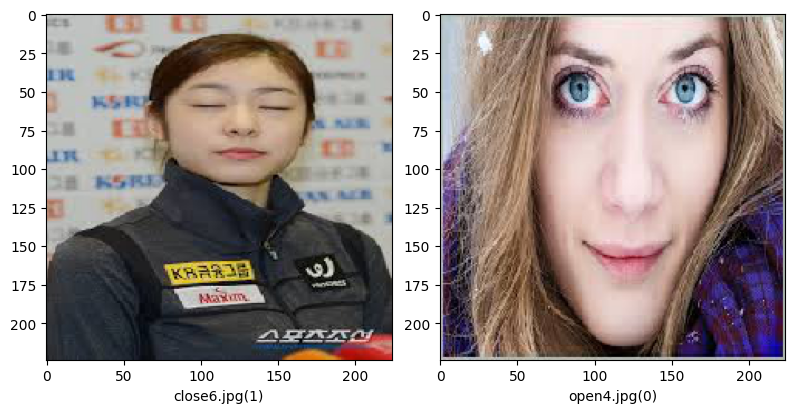

In [80]:
sample_test = test_df.head(2)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("CNN_dataset/cnn_test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()
# close : 1, open : 0